In [252]:
from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
import mlflow
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from code import utils
import nltk,re,time,umap
from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize



In [ ]:
#model = SentenceTransformer('bert-base-wikipedia-sections-mean-tokens')
TOP_N = 1000
TRAIN_N = 10000
# load BERT model from Hugging Face
word_embedding_model = models.Transformer(
    'T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb')

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

# join BERT model and pooling to get the sentence transformer
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [3]:
df=utils.load_text_data().head(TOP_N)
df.created_at =pd.to_datetime(df.created_at,dayfirst=True)
df.head()

,kicker,headline,text,seo_title,created_at,updated_at,site,entities_analyzed
article_uid,,,,,,,,
8c7b60bbbbab27058f93ba3114462b0b9b82f79c3cf3e95e52cf8013742b1f89,Tor nach 3 Sekunden!,Blitz-Comeback von Reus,Wenn du bei deinem Comeback nach 223 Tagen nur...,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,2020-09-14 22:39:16,2020-09-14 22:39:16,www.bild.de,0
66ef992ac10f512ce621314bcffcbc542549ba1f52c8b11696e33d8730998aba,Sie stoppten das Schalke-Spiel,Türkgücü-Bosse erklärenihre Pokal-Klage,Es war DER Aufreger der 1. DFB-Pokal-Runde. T...,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
bafa8f876a14f50c6010a8ea2ff4de2265e508af13c5007ddb363a4c4b155f4e,Messer-Angriff von Stolberg,Islamist stachschon einmal zu!,Stolberg/Aachen – Der Messerangriff von Stolbe...,Messer-Angriff von Stolberg - Islamist stach...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
e353f0b8121a6f0addf3ea3ca5eead419c904d283284fcffcf913ff6f2f39b1c,Hertha verschenkt Machtzentrale,Die neuen Hierarchien der 18 Klubs,Die neue Serie „Die neuen Hierarchien der 18 K...,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,2020-09-14 22:34:15,2020-09-14 22:35:05,www.bild.de,1
f168dc072b52b38187937175639830ef066209100ffaeea780cb03cd943706d3,Verletzte und neue Offensive,Gisdol schon vorm Start unter Druck!,Das hatte sich Markus Gisdol (50) bei seiner V...,1. FC Köln: Markus Gisdol schon vor Liga-Start...,2020-09-14 22:33:16,2020-09-14 22:34:07,www.bild.de,1


In [4]:
pdf=utils.preprocess_text(df)
df['mix'] = df['kicker'] + " " + df['headline'] +" "+ df["seo_title"]
pdf_mix = utils.preprocess_text(df,col="mix")
pdf_mix[0][:250]

'tor nach sekunden blitz-comeback von reus dfb-pokal duisburg bvb sekunden nach einwechslung reus mit blitz-torfussball'

In [5]:

start_time = time.time()

embeddings = model.encode(pdf,show_progress_bar=True)
print("--- %s seconds ---" % (time.time() - start_time))



--- 337.29122400283813 seconds ---


In [6]:

print(embeddings.shape)
umap_data = umap.UMAP(n_neighbors=25, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)


(1000, 768)


In [26]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=384, 
                            metric='cosine').fit_transform(embeddings)


In [227]:
cluster = HDBSCAN(min_cluster_size=6,alpha=0.88,cluster_selection_epsilon=0.11,
                          prediction_data=True
                          ,metric='euclidean',                     min_samples=3,
                          cluster_selection_method='eom',approx_min_span_tree=True).fit(umap_embeddings)

In [233]:
# Prepare data
result = pd.DataFrame(umap_data, columns=['x', 'y','z'])
result['labels'] = cluster.labels_
result['headline'] = df.head(TOP_N)["seo_title"].values
result['seo_title'] = df.head(TOP_N)["headline"].values

result['created_at'] = df.head(TOP_N)["created_at"].dt.date.values
result.sort_values(by="created_at")
result['created_at'] = result.created_at.apply(str)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
print("Outliers: {} | Clustered: {} | {} \n Cluster count: {} ".format(len(outliers),len(clustered),
                                                                 (len(clustered)/(len(outliers)+len(clustered)))
                                                                 ,len(clustered.labels.unique())))

result

Outliers: 192 | Clustered: 808 | 0.808 
 Cluster count: 55 


,x,y,z,labels,headline,seo_title,created_at
0,9.729743,14.979012,0.108605,-1,DFB-Pokal: Duisburg - BVB 0:5! 3 Sekunden nach...,Blitz-Comeback von Reus,2020-09-14
1,9.197711,14.434338,1.324959,32,DFB-Pokal: Sie stoppten das Schalke-Spiel – Tü...,Türkgücü-Bosse erklärenihre Pokal-Klage,2020-09-14
2,10.630483,12.926833,4.455839,43,Messer-Angriff von Stolberg - Islamist stach...,Islamist stachschon einmal zu!,2020-09-14
3,8.859873,14.838832,-0.087166,50,1. Bundesliga: Die neuen Hierarchien der 18 Kl...,Die neuen Hierarchien der 18 Klubs,2020-09-14
4,8.768867,14.842842,0.266970,-1,1. FC Köln: Markus Gisdol schon vor Liga-Start...,Gisdol schon vorm Start unter Druck!,2020-09-14
...,...,...,...,...,...,...,...
995,10.048791,14.172144,2.956674,41,Weil Verdi nicht mitspielt - VerkaufsZOFFene S...,VerkaufsZOFFene Sonntage,2020-09-09
996,9.576859,15.112974,3.456053,14,Erfindung aus Nürnberg - Frischer Salat aus de...,Frischer Salat aus dem Automaten,2020-09-09
997,10.067616,14.658819,2.218959,-1,OB Henriette Reker: „Klimaneutrales Köln will ...,Reker: „Klimaneutrales Köln will ich noch erle...,2020-09-09
998,10.115217,15.351738,1.772552,-1,NFL: „Vollmer und Kuhn“-Show ist der Football-...,Buccaneers lösen Versprechenvon Bradys Ex-Klub...,2020-09-09


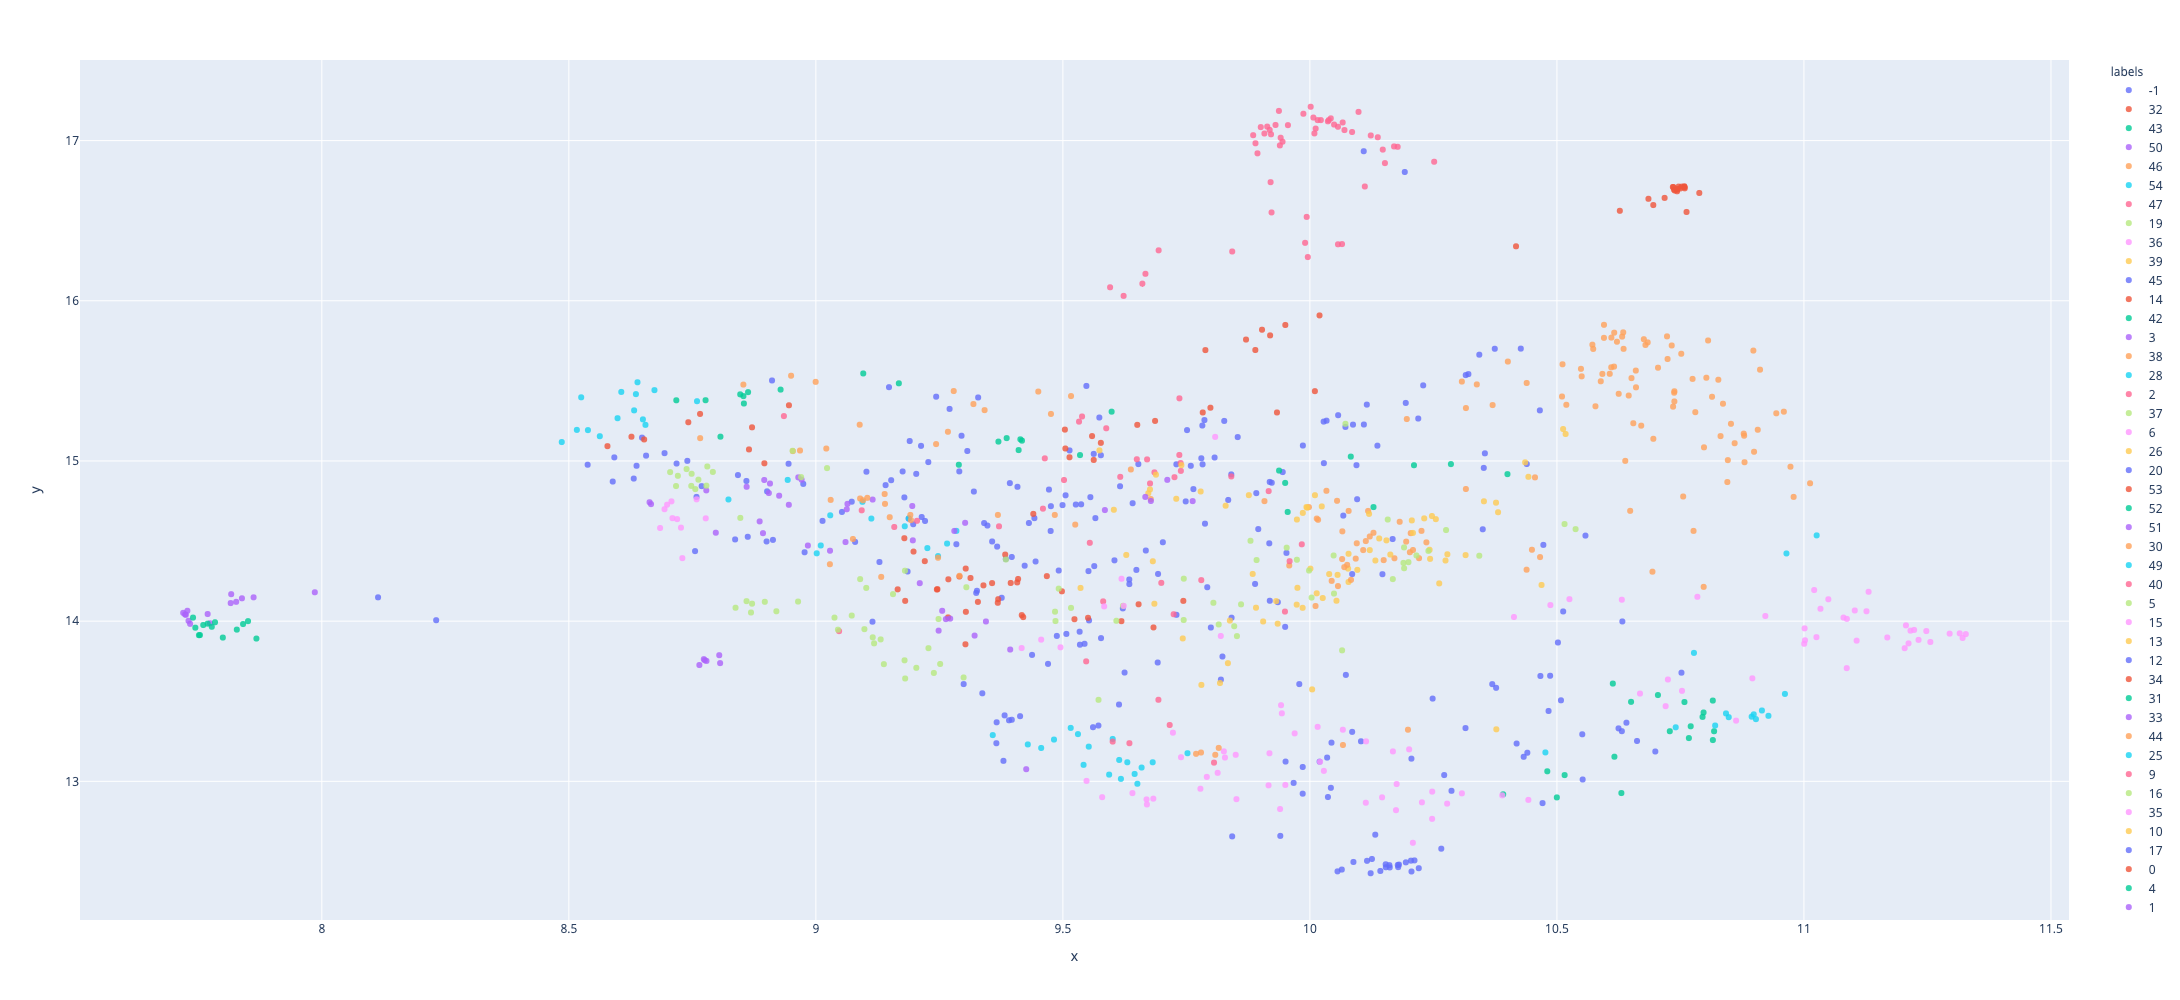

In [234]:
result["labels"] = result.labels.apply(str)
fig = px.scatter(result, x="x", y="y",hover_name="headline",hover_data=["created_at"], color = "labels",opacity=0.8)
fig["layout"].pop("updatemenus")
fig.update_layout(
     height=1000)
fig.show()

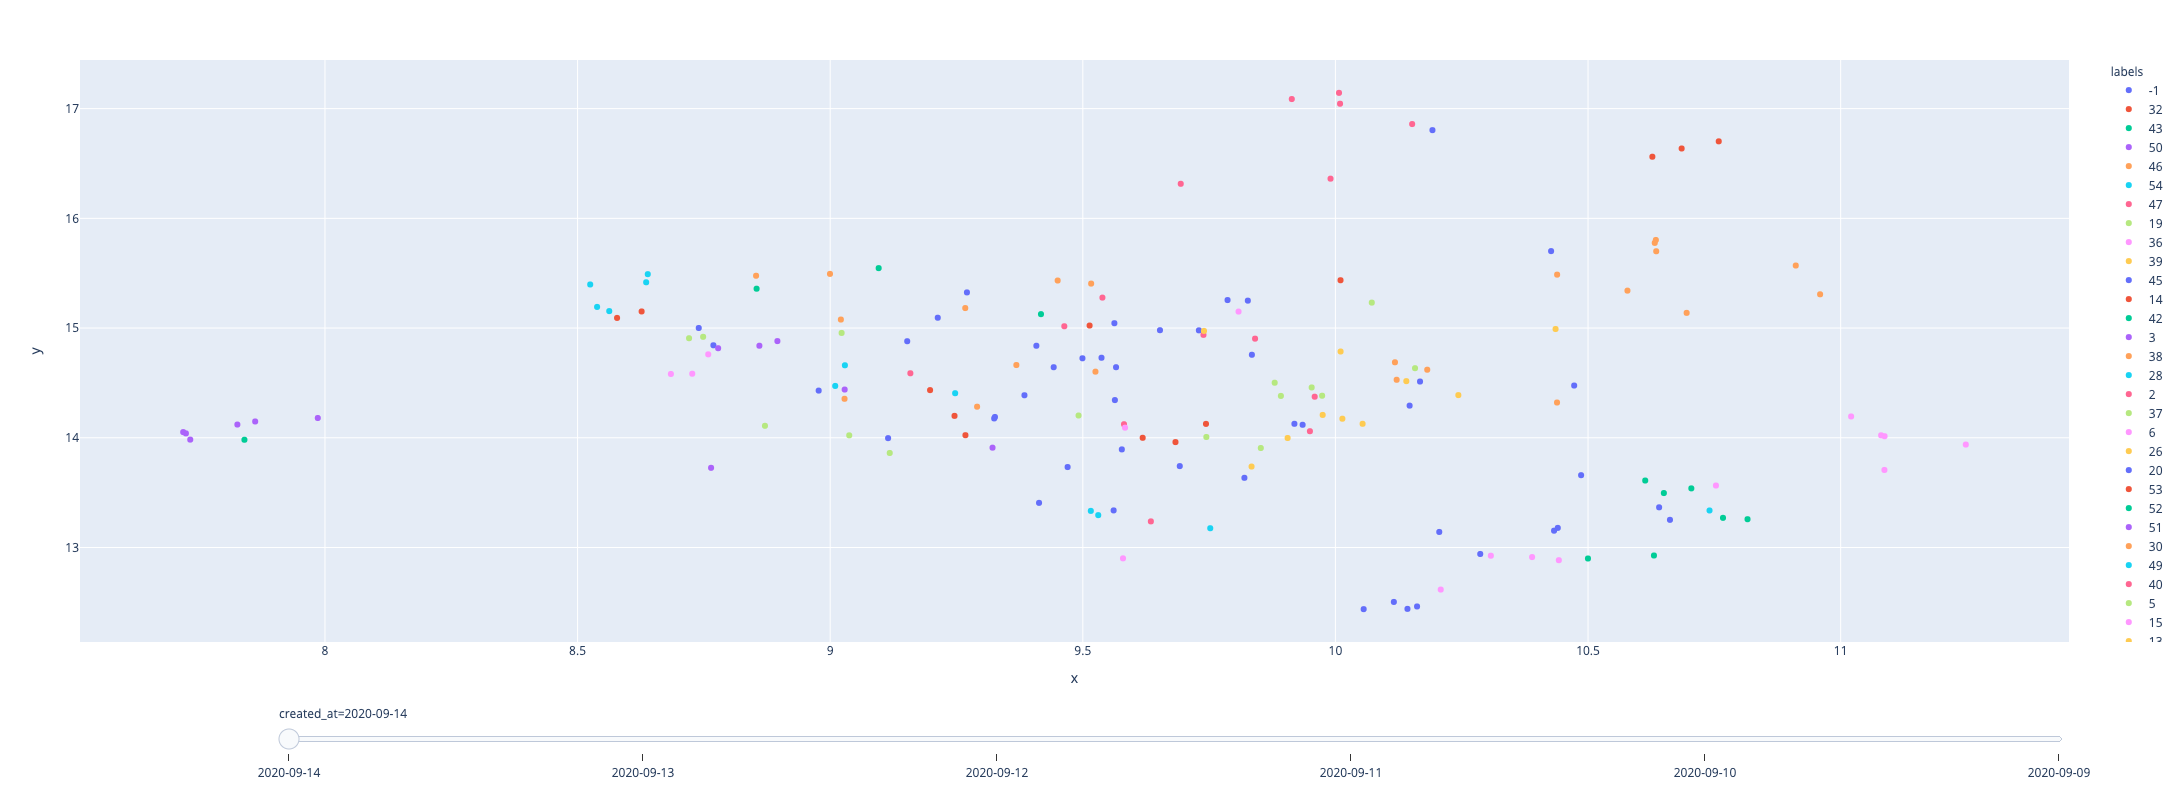

In [235]:

fig = px.scatter(result, x="x", y="y",hover_name="headline", color = "labels", animation_frame="created_at")
fig["layout"].pop("updatemenus")
fig.update_layout(
     height=800)
fig.show()

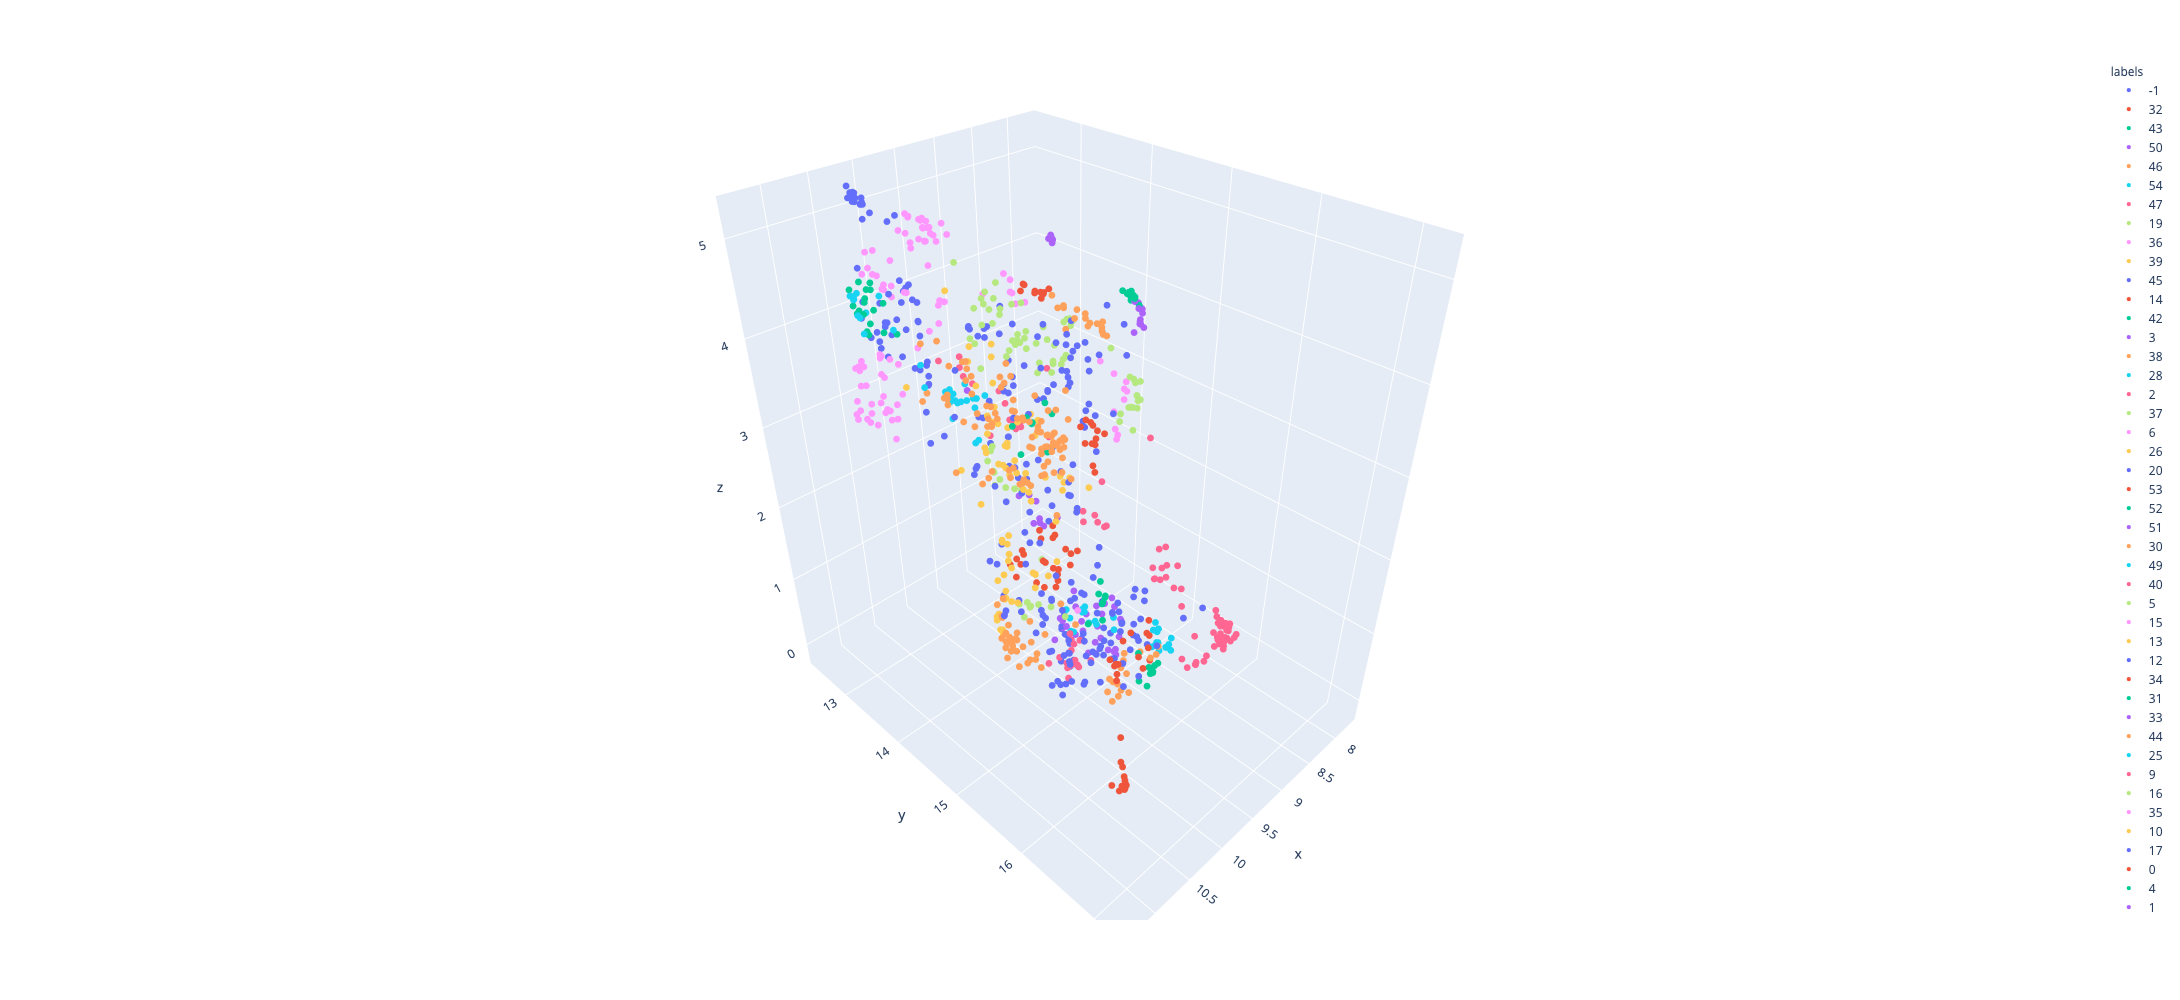

In [236]:


fig = px.scatter_3d(
    result, x='x', y='y', z='z',hover_name="headline",
    color='labels', labels={'color': 'species'}
)
fig.update_traces(marker_size=4)
fig.update_layout(
     height=1000)
fig.show()


In [237]:
docs_df = pd.DataFrame(pdf_mix, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] =df.index.values#df["article_uid"]#range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


In [238]:
def remove_stop_words(doc):
    for sword in utils.STOPWORDS:
        doc=doc.replace(sword,"")
        return doc
    
def c_tf_idf(documents, m, ngram_range=(1, 2)):
    #documents=np.array(list(map(remove_stop_words, documents)))
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(df.text.values, m=len(pdf))

In [239]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
top_3_words_per_topic = pd.DataFrame([(k," | ".join([e[0] for e in v][:5]))  for (k,v) in top_n_words.items()],columns=["Topic","top_n_words"])
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(100)


,Topic,Size
0,-1,192
31,30,86
3,2,53
16,15,40
39,38,33
17,16,29
13,12,25
19,18,24
33,32,24
1,0,21


In [240]:
top_3_words_per_topic["Topic"]=top_3_words_per_topic["Topic"].apply(str)

In [241]:
results = pd.merge(result, top_3_words_per_topic, how='left', left_on="labels",right_on="Topic")

In [243]:
results.groupby(["created_at",'labels',"top_n_words"]).count()

x   y  \
created_at labels top_n_words                                                  
2020-09-09 -1     reus | watzke | hazard | bellingham | teenie        29  29   
           0      türkgücü | schweinfurt | von schweinfurt | klag...   1   1   
           10     dynamo | dynamo dresden | bei dynamo | dresdner...   1   1   
           11     juwelier | celle | bernd | darauf mit | unter s...   4   4   
           12     haidara | in nürnberg | tyler adams | bei rb | ...   3   3   
...                                                                   ..  ..   
2020-09-14 52     zunahme | zahl der | die zahl | senioren | lka ...   2   2   
           53     celle | täter | großeinsatz der | überfalls | ü...   2   2   
           54     raab | stefan raab | stefan | luke | mockridge       5   5   
           6      metzelder | zeugin | anwälte | christoph metzel...   3   3   
           9      jagatic | chemie | chemie leipzig | jagatic des...   2   2   

                                                                       z  \
created_at labels top_n_words                                              
2020-09-09 -1     reus | watzke | hazard | bellingham | teenie        29   
           0      türkgücü | schweinfurt | von schweinfurt | klag...   1   
           10     dynamo | dynamo dresden | bei dynamo | dresdner...   1   
           11     juwelier | celle | bernd | darauf mit | unter s...   4   
           12     haidara | in nürnberg | tyler adams | bei rb | ...   3   
...                                                                   ..   
2020-09-14 52     zunahme | zahl der | die zahl | senioren | lka ...   2   
           53     celle | täter | großeinsatz der | überfalls | ü...   2   
           54     raab | stefan raab | stefan | luke | mockridge       5   
           6      metzelder | zeugin | anwälte | christoph metzel...   3   
           9      jagatic | chemie | chemie leipzig | jagatic des...   2   

                                                                      headline  \
created_at labels top_n_words                                                    
2020-09-09 -1     reus | watzke | hazard | bellingham | teenie              29   
           0      türkgücü | schweinfurt | von schweinfurt | klag...         1   
           10     dynamo | dynamo dresden | bei dynamo | dresdner...         1   
           11     juwelier | celle | bernd | darauf mit | unter s...         4   
           12     haidara | in nürnberg | tyler adams | bei rb | ...         3   
...                                                                        ...   
2020-09-14 52     zunahme | zahl der | die zahl | senioren | lka ...         2   
           53     celle | täter | großeinsatz der | überfalls | ü...         2   
           54     raab | stefan raab | stefan | luke | mockridge             5   
           6      metzelder | zeugin | anwälte | christoph metzel...         3   
           9      jagatic | chemie | chemie leipzig | jagatic des...         2   

                                                                      seo_title  \
created_at labels top_n_words                                                     
2020-09-09 -1     reus | watzke | hazard | bellingham | teenie               29   
           0      türkgücü | schweinfurt | von schweinfurt | klag...          1   
           10     dynamo | dynamo dresden | bei dynamo | dresdner...          1   
           11     juwelier | celle | bernd | darauf mit | unter s...          4   
           12     haidara | in nürnberg | tyler adams | bei rb | ...          3   
...                                                                         ...   
2020-09-14 52     zunahme | zahl der | die zahl | senioren | lka ...          2   
           53     celle | täter | großeinsatz der | überfalls | ü...          2   
           54     raab | stefan raab | stefan | luke | mockridge              5   
           6      metzelder | zeugin | anwälte | christoph me

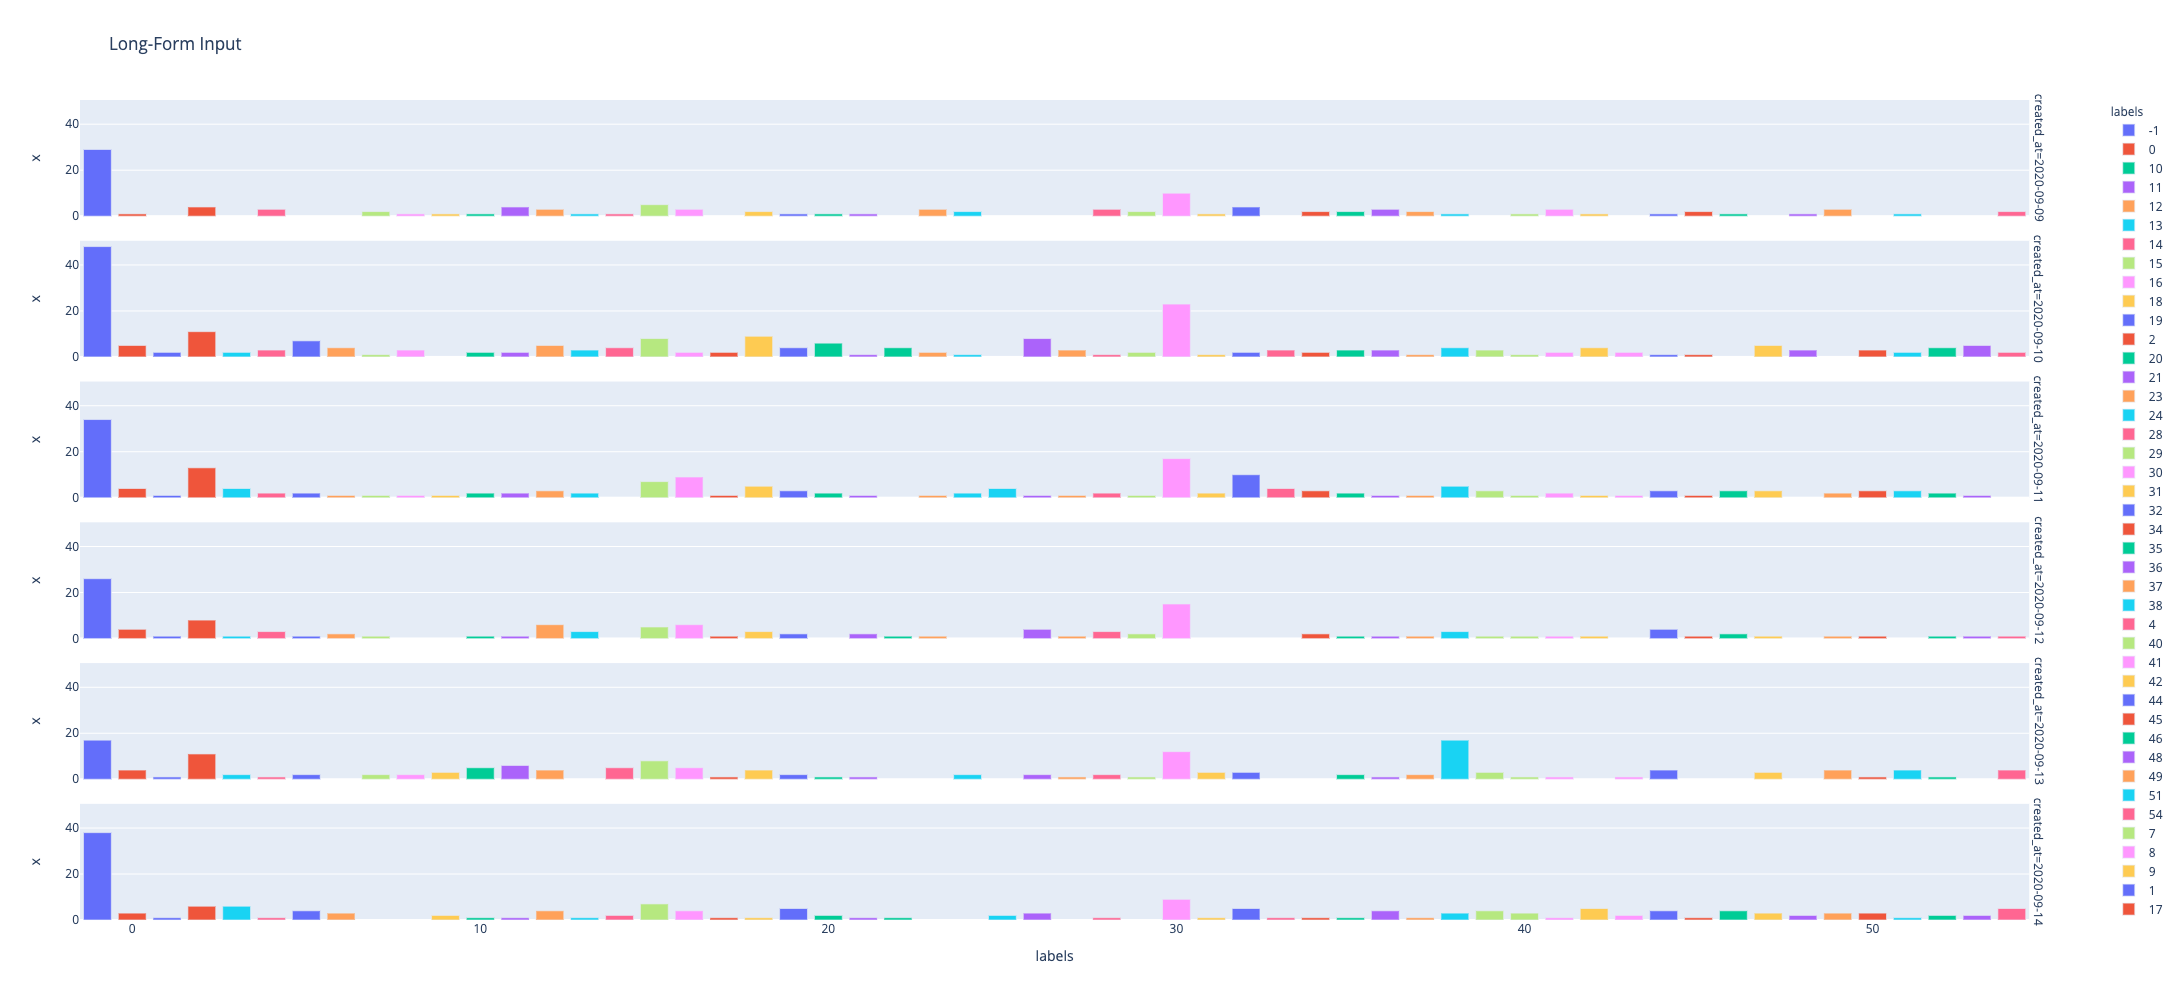

In [249]:
fig = px.bar(results.groupby(["created_at",'labels',"top_n_words"]).count().reset_index(), x="labels", y="x", color="labels",hover_name="top_n_words",title="Long-Form Input",facet_row="created_at")
fig.update_layout(
     height=1000)

fig.show()